In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Loading the Images

In [2]:
# Function to process image into array matching the size for the trained model
def process_img(img_path, target_size=(256, 256)):
    try:
        image = imread(img_path)
        img_array = resize(image, target_size, anti_aliasing=True)
        img_array = img_array.flatten()
        return img_array
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [3]:
# Function to load images from a directory and preprocess them
def load_img_from_directory(directory, target_size=(256, 256)):
    data = []
    labels = []
    class_names = [folder for folder in os.listdir(directory) if folder != ".DS_Store"]
    for label in class_names:
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for img in os.listdir(label_dir):
                if img.endswith((".jpg", ".jpeg", ".png")):
                    img_path = os.path.join(label_dir, img)
                    img_array = process_img(img_path, target_size)
                    if img_array is not None:
                        data.append(img_array)
                        labels.append(label)
    return np.array(data), np.array(labels), class_names

In [4]:
X, y, class_names = load_img_from_directory("../image_data/", target_size=(256, 256))
X.shape

(650, 196608)

In [5]:
# Checking number of images in total
print(len(X))

650


### Encoding Labels

In [6]:
label_encoder = {'logos': 1, 'not_logos': 0}
y = np.array([label_encoder[label] for label in y])

In [7]:
# Checking the count of not_logos (0) and logos (1) in dataset
np.unique(y, return_counts=True)

(array([0, 1]), array([433, 217]))

### Splitting the Dataset

In [8]:
# Splitting the datasets into train and test ones
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Overview of sizes of the different sets
print(f"training data size: {X_train.shape}, testing data size: {X_test.shape}")
print(f"training results size: {y_train.shape}, testing results size: {y_test.shape}")

training data size: (520, 196608), testing data size: (130, 196608)
training results size: (520,), testing results size: (130,)


In [10]:
# Checking the count of not_logos (0) and logos (1) in the testing dataset
np.unique(y_test, return_counts=True)

(array([0, 1]), array([80, 50]))

### Random Forest Classifier

In [11]:
# initialising a model
random_forest = RandomForestClassifier(random_state=42)

# Train the model
random_forest.fit(X_train, y_train)

# Predict on the test set
y_pred = random_forest.predict(X_test)

In [12]:
# Overview of the model
random_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [13]:
# Get the depth of each tree in the forest
random_forest_max_depths = []
for tree in random_forest.estimators_:
    random_forest_max_depths.append(tree.tree_.max_depth)

# Get the min and max depth among all trees
min_depth = min(random_forest_max_depths)
max_depth = max(random_forest_max_depths)
print(f"Minimum depth of the trees in the random forest model: {min_depth}\
      \nMaximum depth of trees in the random forest: {max_depth}")

Minimum depth of the trees in the random forest model: 5      
Maximum depth of trees in the random forest: 13


### Hyperparameter Tuning

In [14]:
# Hyperparameter tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    "max_depth": range(7, 11),
    "n_estimators": [150, 200, 250]
    # "min_samples_split": [2, 3, 4]
    }

# Initialize GridSearchCV and fit it to the training data
grid_search = GridSearchCV(random_forest, param_grid, n_jobs=-1, scoring="accuracy", cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(7, 11),
                         'n_estimators': [150, 200, 250]},
             scoring='accuracy')

In [15]:
# Checking the best parameters
print(f"Best parameters for Random Forest: {grid_search.best_params_}")
print(f"Best cross-validated accuracy for Random Forest: {round((grid_search.best_score_)*100, 2)}%")

Best parameters for Random Forest: {'max_depth': 7, 'n_estimators': 200}
Best cross-validated accuracy for Random Forest: 89.04%


Note: I have commented out the min_samples_split after some testing, as it seems to take too long to run but doesn't impact the model much. I am therefore only tuning max_depth and n_estimators.

In [16]:
# Train the model with tuned max_depths
random_forest_tuned = RandomForestClassifier(**grid_search.best_params_, random_state=42)
random_forest_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_estimators=200, random_state=42)

In [17]:
# Getting an array of scores for each image prediction
y_pred_scores = random_forest_tuned.predict_proba(X_test)[:, 1]
y_pred_scores

array([5.36692461e-01, 7.22644977e-01, 4.08082631e-02, 8.17101152e-02,
       4.16477742e-01, 1.63501843e-01, 7.18396186e-01, 7.15144955e-01,
       2.04177220e-02, 7.16225062e-03, 4.09375013e-02, 2.05187321e-02,
       7.06028578e-02, 7.88622241e-01, 5.47689110e-03, 2.66981232e-01,
       3.05187321e-02, 7.12798069e-01, 7.74558387e-01, 6.34781589e-01,
       1.74547570e-01, 7.28762415e-01, 3.31777326e-01, 7.56577584e-01,
       2.23986301e-01, 6.70838552e-02, 7.14936156e-01, 2.05187321e-02,
       2.36790441e-01, 9.73726490e-01, 3.55031932e-01, 4.85143794e-01,
       8.46681179e-01, 4.95206201e-01, 1.25686140e-01, 5.05338791e-01,
       8.11691381e-01, 7.26598020e-01, 8.45769627e-01, 7.18754719e-01,
       8.16591406e-01, 3.01873211e-03, 2.26701263e-02, 8.50327366e-01,
       3.79623981e-01, 4.18186167e-01, 1.52288770e-02, 1.54537430e-02,
       8.58114260e-01, 1.03369139e-02, 1.10554312e-01, 7.29445241e-01,
       3.87067532e-01, 4.98681295e-01, 6.69064463e-01, 3.72227237e-01,
      

I'd like to take a look at the precision-recall and accuracy curve and potentially tune on the threshold of the  I'd be happy to opt for a threshold where the recall is high, as I'd like the model to find as many instances of a true Laura Ashley tag as possible (lower false negative).

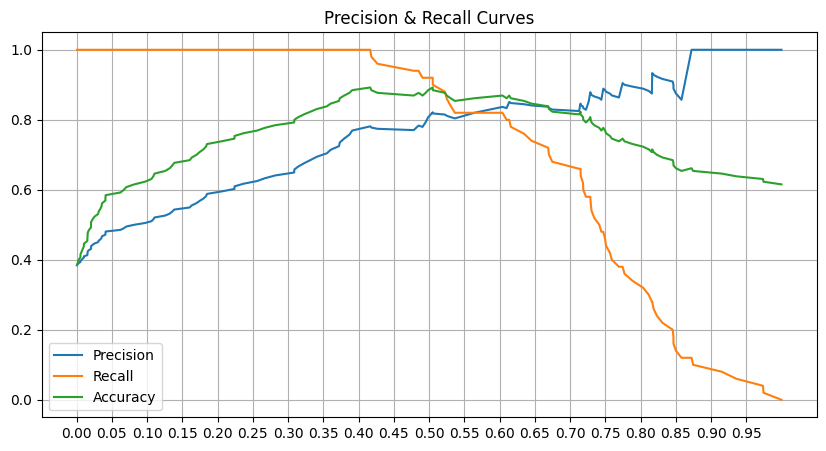

In [18]:
# Calculate precision, recall, and thresholds for the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_scores)

thresholds = np.append(thresholds, 1) # Adding a threshold to match precision and recall lengths

accuracies = [accuracy_score(y_test, y_pred_scores >= t) for t in thresholds]

plt.figure(figsize=(10, 5))
plt.plot(thresholds, precision, label=f'Precision')
plt.plot(thresholds, recall, label=f'Recall')
plt.plot(thresholds, accuracies, label="Accuracy")
plt.title('Precision & Recall Curves')
plt.grid(True)
plt.legend(loc="best")
plt.xticks(np.arange(0, 1, 0.05))
plt.show()

Based on the plotted curves, I am happy to use the default threshold of 0.5 as it provides a balanced trade-off between precision and recall.

In [44]:
# Predict using the tuned random forest on the test set, also setting the threshold
y_pred_tuned = (random_forest_tuned.predict(X_test))

### Confusion Matrix

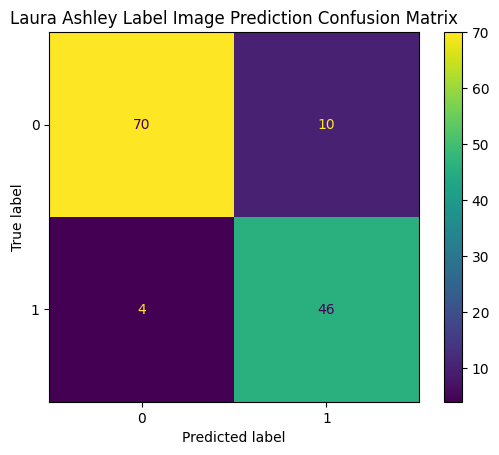

In [45]:
# Creating a Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned)
cm_diagram = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_diagram.plot()
plt.title("Laura Ashley Label Image Prediction Confusion Matrix")
plt.show()

In [46]:
# Taking a look at the predictions of wrong image by getting their index position
wrong_img = np.where(y_pred_tuned != y_test)
fig_num = int(sum(len(array) for array in wrong_img))
fig_num

14

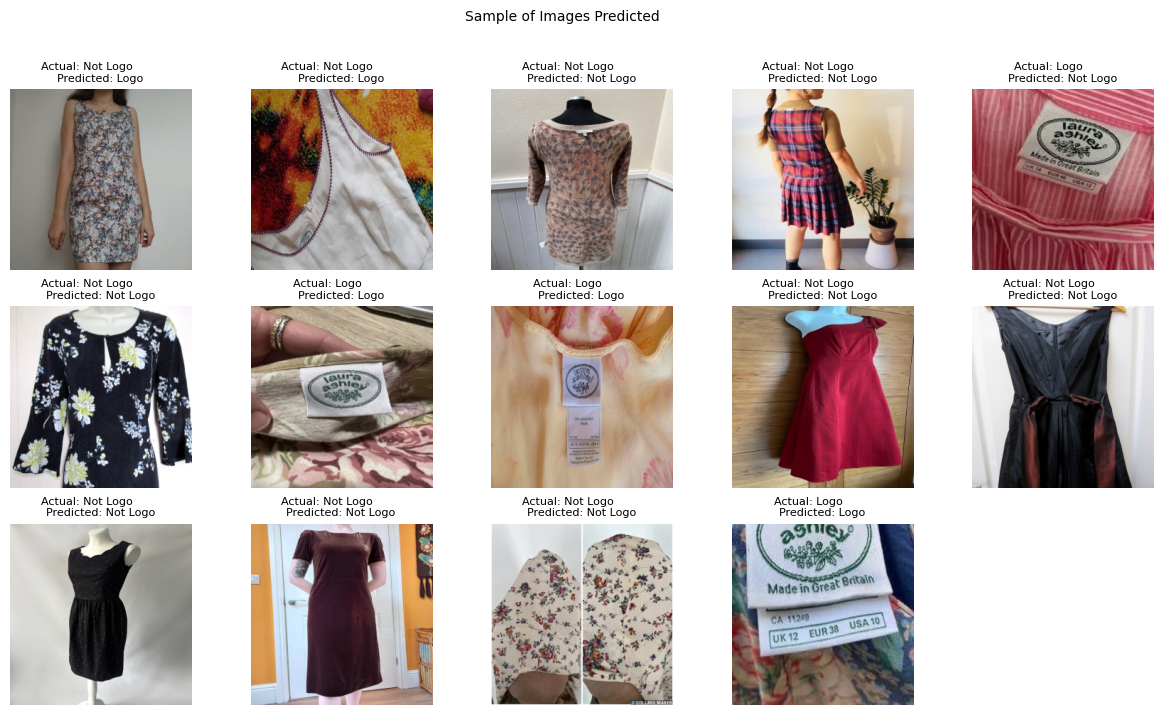

In [47]:
plt.figure(figsize=(15,8))
for i in range(fig_num):
    plt.subplot(3, int(np.ceil(fig_num/3)), i + 1)
    plt.imshow(np.reshape(X_test[i], (256, 256, 3)))
    plt.axis("off")
    plt.title(f"Actual: {'Logo' if y_test[i]==1 else 'Not Logo'}\
        \nPredicted: {'Logo' if y_pred_tuned[i]==1 else 'Not Logo'}", fontsize=8)

# Titles
plt.suptitle("Sample of Images Predicted", fontsize=10)
plt.show()

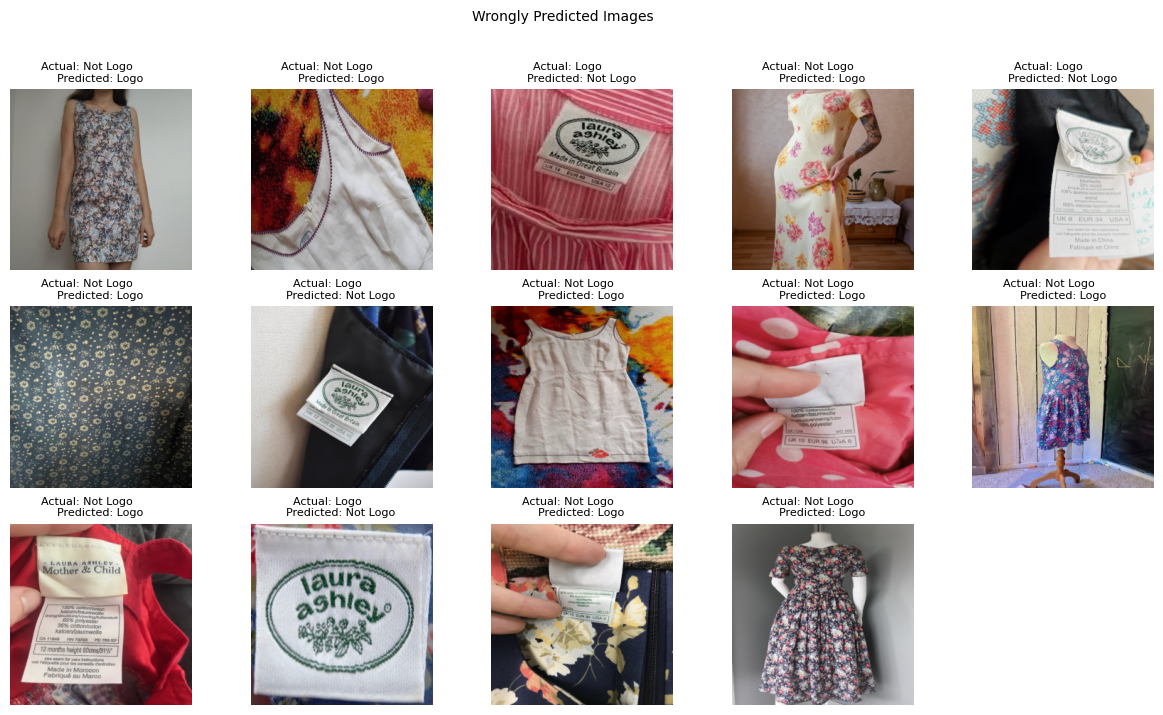

In [48]:
# Plotting the wrongly-predicted images 
plt.figure(figsize=(15,8))
for index, (image, label, predict) in enumerate(zip(X_test[wrong_img], y_test[wrong_img], y_pred_tuned[wrong_img])):
    plt.subplot(3, int(np.ceil(fig_num/3)), index + 1)
    plt.imshow(np.reshape(image, (256, 256, 3)))
    plt.axis("off")
    plt.title(f"Actual: {'Logo' if label==1 else 'Not Logo'}\
        \nPredicted: {'Logo' if predict==1 else 'Not Logo'}", fontsize=8)
# Titles
plt.suptitle("Wrongly Predicted Images", fontsize=10)
plt.show()

### Model Performance Evaluation

In [49]:
# Calculating the evaluation scores
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc_score = accuracy_score(y_test, y_pred_tuned)
pre_score = precision_score(y_test, y_pred_tuned, average="macro")
rec_score = recall_score(y_test, y_pred_tuned, average="macro")
fone_score = f1_score(y_test, y_pred_tuned, average="macro")

print(f"Accuracy Score: {round(acc_score*100, 2)}%,\
      \nPrecision Score: {round(pre_score*100, 2)}%,\
      \nRecall Score: {round(rec_score*100, 2)}%,\
      \nF1 Score: {round(fone_score*100, 2)}%")

Accuracy Score: 89.23%,      
Precision Score: 88.37%,      
Recall Score: 89.75%,      
F1 Score: 88.85%


The model demonstrates strong performance with an accuracy score of 89.23%. The recall score of 89.75% highlights its effectiveness in capturing actual positives to identify Laura Ashley logo tags. Although the precision score is slightly lower, it meets the requirement of balancing high accuracy and recall as previously explained. The F1 score, which reflects the harmonic mean of precision and recall, further confirms that the classification model is well-balanced and performs effectively.

In [50]:
# Save the trained model to a file
import pickle

with open("../src/logo_identifier.pkl", "wb") as file:
    pickle.dump(random_forest_tuned, file)